<a href="https://colab.research.google.com/github/Eduardofabian/REDE_NEURAL_TCC_FABIAN/blob/main/c_digo_att_ulltimo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error


# 1. PARÂMETROS FIXOS (GEOMETRIA BASE)

---




In [ ]:
print("\n" + "="*50)
print("OTIMIZAÇÃO DA ALTURA H1 (H2 = 2140.8495 - H1)")
print("="*50)


parametros_fixos = {
    'FLUIDO': {
        'Densidade (kg/m³)': 997
    },
    'INLET': {
        'Diâmetro Inicial (mm)': 1280.747,
        'Velocidade de Entrada (m/s)':4.83
    },
    'OUTLET': {
        'Altura Final (mm)': 2500,
        'Largura Final (mm)': 2500,
        'Área Final (mm²)': 6250000,
        'Velocidade de Saída (m/s)': 1.34
    },
    'SÓLIDO 3': {
        'Comprimento (mm)': 2533.0,
        'Raio (mm)': 1728.0714,
        'Ângulo (°)': 83.99
    },
    'DUTO': {
        'Altura Total (mm)': 4937.845
    }
}
# Definir a altura máxima permitida para H1 + H2
ALTURA_MAXIMA = 2140.8495  # mm
# Mostrar parâmetros fixos
for componente, subparams in parametros_fixos.items():
    print(f"\n{componente}:")
    for param, valor in subparams.items():
        print(f"  {param}: {valor}")



OTIMIZAÇÃO DA ALTURA H1 (H2 = 2140.8495 - H1)

FLUIDO:
  Densidade (kg/m³): 1.225

INLET:
  Diâmetro Inicial (mm): 1280.747
  Velocidade de Entrada (m/s): 18409.0

OUTLET:
  Altura Final (mm): 2500
  Largura Final (mm): 2500
  Área Final (mm²): 6250000
  Velocidade de Saída (m/s): 8012.0

SÓLIDO 3:
  Comprimento (mm): 2533.0
  Raio (mm): 1728.0714
  Ângulo (°): 83.99

DUTO:
  Altura Total (mm): 4937.845


# 2. DADOS DE SIMULAÇÃO (TESTES CFD) - VALORES DO ANSYS


In [ ]:
testes_cfd = [
    {
        'Caso': 'Teste 3',
        'H1 (mm)': 1400.0,
        'H2 (mm)': 740.8893,
        'Pressões': {
            'Estática Entrada (Pa)': 8683.360,
            'Estática Saída (Pa)': 0.092,
            'Dinâmica Entrada (Pa)': 11600.800,
            'Dinâmica Saída (Pa)': 1093.500
        },
        'Velocidade Entrada (m/s)': 18409.0,
        'Velocidade Saída (m/s)': 8012.0,
        'NW': 0.817  # Valor direto do ANSYS
    },
    {
        'Caso': 'Teste 1',
        'H1 (mm)': 950.0,
        'H2 (mm)': 1190.83,
        'Pressões': {
            'Estática Entrada (Pa)': 7500.0,
            'Estática Saída (Pa)': 0.085,
            'Dinâmica Entrada (Pa)': 10000.0,
            'Dinâmica Saída (Pa)': 900.0
        },
        'Velocidade Entrada (m/s)': 18000.0,
        'Velocidade Saída (m/s)': 7800.0,
        'NW': 0.738  # Valor direto do ANSYS
    },
    {
        'Caso': 'Teste 2',
        'H1 (mm)': 1150.0,
        'H2 (mm)': 992.8284,
        'Pressões': {
            'Estática Entrada (Pa)': 8683.360,
            'Estática Saída (Pa)': 0.092,
            'Dinâmica Entrada (Pa)': 11600.800,
            'Dinâmica Saída (Pa)': 1093.500
        },
        'Velocidade Entrada (m/s)': 18000.0,
        'Velocidade Saída (m/s)': 7900.0,
        'NW': 0.918  # Valor direto do ANSYS
    },
]

# Converter para DataFrame expandido
dados_testes = []
for teste in testes_cfd:
    row = {
        'Caso': teste['Caso'],
        'H1 (mm)': teste['H1 (mm)'],
        'H2 (mm)': teste['H2 (mm)'],
        **teste['Pressões'],
        'Velocidade Entrada (m/s)': teste['Velocidade Entrada (m/s)'],
        'Velocidade Saída (m/s)': teste['Velocidade Saída (m/s)'],
        'NW': teste['NW']  # Usando o valor do ANSYS diretamente
    }
    dados_testes.append(row)

df_testes = pd.DataFrame(dados_testes)

print("\nPARÂMETROS VARIÁVEIS DOS TESTES CFD")
print("="*50)
print(df_testes.to_markdown(index=False, floatfmt=".4f"))


PARÂMETROS VARIÁVEIS DOS TESTES CFD
| Caso    |   H1 (mm) |   H2 (mm) |   Estática Entrada (Pa) |   Estática Saída (Pa) |   Dinâmica Entrada (Pa) |   Dinâmica Saída (Pa) |   Velocidade Entrada (m/s) |   Velocidade Saída (m/s) |     NW |
|:--------|----------:|----------:|------------------------:|----------------------:|------------------------:|----------------------:|---------------------------:|-------------------------:|-------:|
| Teste 3 | 1400.0000 |  740.8893 |               8683.3600 |                0.0920 |              11600.8000 |             1093.5000 |                 18409.0000 |                8012.0000 | 0.8170 |
| Teste 1 |  950.0000 | 1190.8300 |               7500.0000 |                0.0850 |              10000.0000 |              900.0000 |                 18000.0000 |                7800.0000 | 0.7380 |
| Teste 2 | 1150.0000 |  992.8284 |               8683.3600 |                0.0920 |              11600.8000 |             1093.5000 |                 18000.0

# 3. PRÉ-PROCESSAMENTO DOS DADOS

> Adicionar aspas



In [ ]:
df_testes['Razão H2/H1'] = df_testes['H2 (mm)'] / df_testes['H1 (mm)']
df_testes['Área Inlet (mm²)'] = np.pi * (df_testes['H1 (mm)']/2)**2
df_testes['Razão Áreas'] = parametros_fixos['OUTLET']['Área Final (mm²)'] / df_testes['Área Inlet (mm²)']
df_testes['Perda Carga (Pa)'] = df_testes['Estática Entrada (Pa)'] - df_testes['Estática Saída (Pa)']

# Selecionar features e target
X = df_testes[['H1 (mm)', 'H2 (mm)', 'Razão H2/H1', 'Área Inlet (mm²)', 'Razão Áreas']].values
y = df_testes['NW'].values.reshape(-1, 1)  # Reshape para 2D

# Normalização - Usando MinMaxScaler para deixar NW entre 0 e 1
scaler_X = StandardScaler()
scaler_y = MinMaxScaler(feature_range=(0, 1))  # NW entre 0 e 1

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y).flatten()  # Volta para 1D para o treinamento

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


# 4. MODELO DE REDE NEURAL


In [ ]:
print("\n" + "="*50)
print("ARQUITETURA DA RNA")
print("="*50)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Saída entre 0 e 1
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

model.summary()


ARQUITETURA DA RNA


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

# 5. TREINAMENTO


TREINAMENTO
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2172 - mae: 0.4630 - val_loss: 0.0057 - val_mae: 0.0753
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - loss: 0.1697 - mae: 0.3978 - val_loss: 0.0057 - val_mae: 0.0757
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1956 - mae: 0.4359 - val_loss: 0.0057 - val_mae: 0.0753
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1654 - mae: 0.3894 - val_loss: 0.0056 - val_mae: 0.0749
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1530 - mae: 0.3689 - val_loss: 0.0056 - val_mae: 0.0748
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1566 - mae: 0.3745 - val_loss: 0.0056 - val_mae: 0.0748
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1508 - mae: 0.3631 - val_loss: 0.0056 - val_mae: 0.0750
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.1947 - mae: 0.4374 - val_loss: 0.0057 - val_mae: 0.0754
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - l

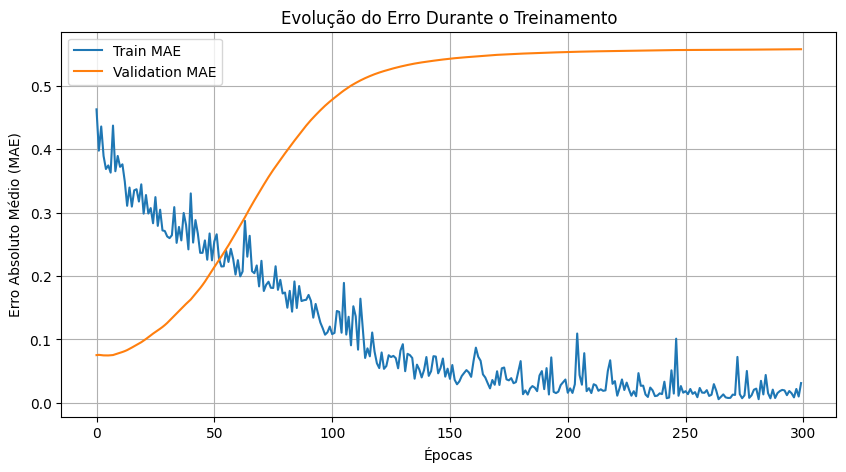

In [ ]:
print("\n" + "="*50)
print("TREINAMENTO")
print("="*50)

history = model.fit(X_train, y_train,
                    epochs=300,
                    batch_size=4,
                    validation_data=(X_test, y_test),
                    verbose=1)

# Plotar histórico de treino
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Evolução do Erro Durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro Absoluto Médio (MAE)')
plt.legend()
plt.grid(True)
plt.show()


# 6. AVALIAÇÃO E PREDIÇÕES



In [ ]:
print("\n" + "="*50)
print("OTIMIZAÇÃO DA ALTURA H1 (H2 = 2140.8495 - H1)")
print("="*50)

def prever_nw(H1):
    """Função auxiliar para prever NW (já desnormalizado)"""
    H2 = 2140.8495 - H1

    razao = H2 / H1
    area_inlet = np.pi * (H1 / 2)**2
    razao_areas = parametros_fixos['OUTLET']['Área Final (mm²)'] / area_inlet

    input_data = np.array([[H1, H2, razao, area_inlet, razao_areas]])
    input_scaled = scaler_X.transform(input_data)
    nw_scaled = model.predict(input_scaled)[0][0]
    return scaler_y.inverse_transform([[nw_scaled]])[0][0]  # Desnormaliza

def encontrar_melhor_h1(model, scaler_X, scaler_y, parametros_fixos,
                        h1_range=(800, 1600), step=50):
    """Encontra a altura H1 que maximiza NW, com H2 = 2140.8495 - H1"""
    best_nw = -np.inf
    best_h1 = None
    best_h2 = None

    # Corrigido: formatação da list comprehension
    for h1 in [x/10 for x in range(int(h1_range[0]*10), int(h1_range[1]*10)+1, int(step*10))]:
        h2 = 2140.8495 - h1
        nw = prever_nw(h1)

        if nw > best_nw:
            best_nw = nw
            best_h1 = h1
            best_h2 = h2

    return best_h1, best_h2, best_nw

# Ajustar faixas de busca para H1
h1_min, h1_max = 800, 1600

# Garantir que H2 resultante fique dentro de limites razoáveis
h1_min = max(h1_min, 2140.8495 - 1500)  # H2 <= 1500
h1_max = min(h1_max, 2140.8495 - 500)   # H2 >= 500

# Encontrar melhores valores
melhor_h1, melhor_h2, melhor_nw = encontrar_melhor_h1(
    model, scaler_X, scaler_y, parametros_fixos,
    h1_range=(h1_min, h1_max),
    step=10  # Passo mais fino para melhor precisão
)

print(f"\nMelhor combinação encontrada (H1 + H2 = {melhor_h1 + melhor_h2:.4f}mm = 2140.8495mm):")
print(f"H1 = {melhor_h1:.1f} mm")
print(f"H2 = {melhor_h2:.1f} mm")
print(f"NW máximo previsto = {melhor_nw:.4f}")


OTIMIZAÇÃO DA ALTURA H1 (H2 = 2140.8495 - H1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1

# 7. ANÁLISE DE SENSIBILIDADE


ANÁLISE DE SENSIBILIDADE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


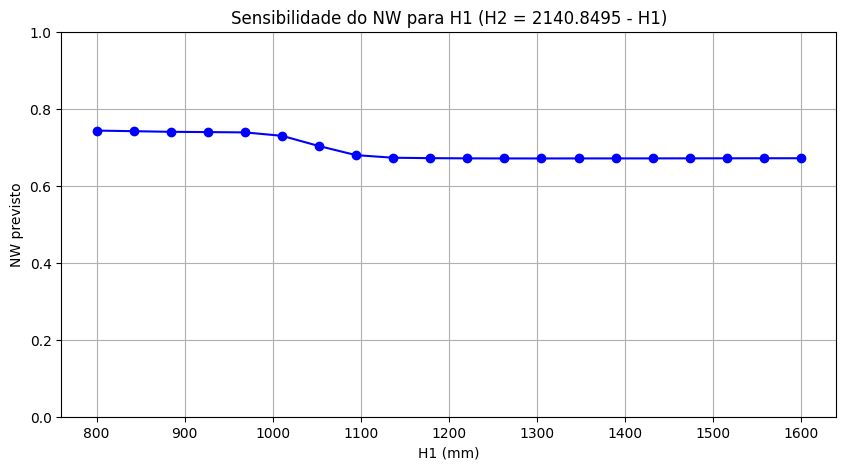

In [ ]:
print("\n" + "="*50)
print("ANÁLISE DE SENSIBILIDADE")
print("="*50)

# Variar H1 e calcular H2 automaticamente (H2 = 2140.8495 - H1)
H1_range = np.linspace(h1_min, h1_max, 20)
nw_values = [prever_nw(H1) for H1 in H1_range]  # Removido o H2_fixo

plt.figure(figsize=(10, 5))
plt.plot(H1_range, nw_values, 'b-', marker='o')
plt.title('Sensibilidade do NW para H1 (H2 = 2140.8495 - H1)')
plt.xlabel('H1 (mm)')
plt.ylabel('NW previsto')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

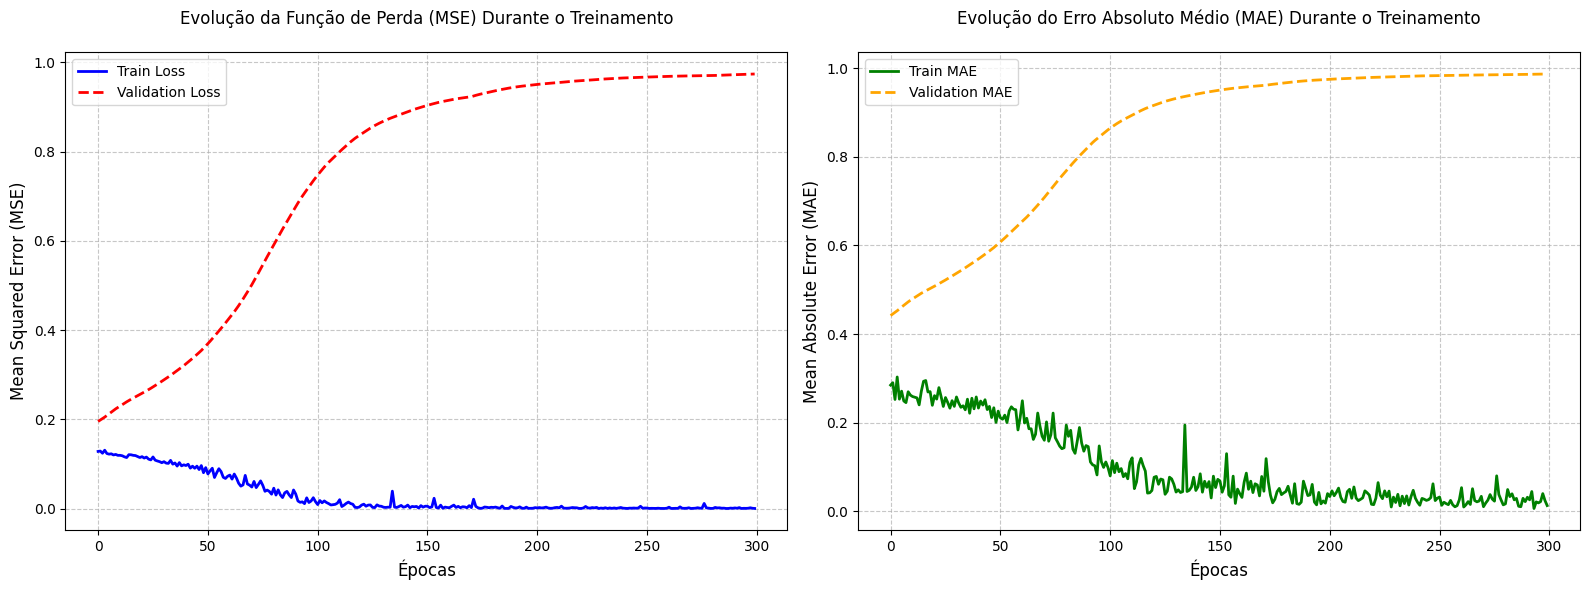

In [ ]:
# Criar figura com dois subplots (uma linha, duas colunas)
plt.figure(figsize=(16, 6))

# Subplot 1: Evolução da Loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2, linestyle='--')
plt.title('Evolução da Função de Perda (MSE) Durante o Treinamento', fontsize=12, pad=20)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Subplot 2: Evolução do MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange', linewidth=2, linestyle='--')
plt.title('Evolução do Erro Absoluto Médio (MAE) Durante o Treinamento', fontsize=12, pad=20)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.savefig('treinamento_rede_neural.png', dpi=300, bbox_inches='tight')
plt.show()